# Classificação de texto com múltiplas classes usando pyspark

Importando pacotes

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import os
import pandas as pd
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
os.environ['JAVA_HOME'] = "C:\Program Files\Java\jre-1.8"

Inicializando sessão

In [3]:
sc = SparkContext(master="local[1]")
sc

<SparkContext master=local[1] appName=pyspark-shell>

Inicializar aplicação SPARK

In [4]:
spark = SparkSession.builder.appName("TextClassifierwithPySpark").getOrCreate()

In [5]:
from datasets import load_dataset
dataset = load_dataset("SetFit/bbc-news")

Found cached dataset json (C:/Users/luanc/.cache/huggingface/datasets/SetFit___json/SetFit--bbc-news-dbeb222bfdd4d6ed/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1225
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1000
    })
})

In [7]:
df_treino = pd.DataFrame(dataset['train'])
df_teste = pd.DataFrame(dataset['test'])

In [8]:
df_treino.to_csv('df_treino.csv', index=False)
df_teste.to_csv('df_teste.csv', index=False)

In [9]:
df_treino = spark.read.csv("df_treino.csv",header=True,inferSchema=True)
df_teste = spark.read.csv("df_teste.csv",header=True,inferSchema=True)

In [10]:
df_treino.show()

+--------------------+-----+-------------+
|                text|label|   label_text|
+--------------------+-----+-------------+
|wales want rugby ...|    2|        sport|
|china aviation se...|    1|     business|
|rock band u2 brea...|    3|entertainment|
|markets signal br...|    1|     business|
|tough rules for r...|    0|         tech|
|iraq advice claim...|    4|     politics|
|brits debate over...|    3|entertainment|
|dirty den s demis...|    3|entertainment|
|lib dems  new ele...|    4|     politics|
|bbc poll indicate...|    1|     business|
|broadband set to ...|    0|         tech|
|domain system ope...|    0|         tech|
|attack prompts bu...|    0|         tech|
|young debut cut s...|    2|        sport|
|new harry potter ...|    3|entertainment|
|speak easy plan f...|    0|         tech|
|pearce keen on su...|    2|        sport|
|playstation 3 pro...|    0|         tech|
|ask jeeves tips o...|    1|     business|
|singer ferguson  ...|    3|entertainment|
+----------

In [11]:
df_treino.show(5)

+--------------------+-----+-------------+
|                text|label|   label_text|
+--------------------+-----+-------------+
|wales want rugby ...|    2|        sport|
|china aviation se...|    1|     business|
|rock band u2 brea...|    3|entertainment|
|markets signal br...|    1|     business|
|tough rules for r...|    0|         tech|
+--------------------+-----+-------------+
only showing top 5 rows



In [12]:
df_treino.groupBy('label_text').count().show()

+-------------+-----+
|   label_text|count|
+-------------+-----+
|        sport|  275|
|     politics|  242|
|entertainment|  210|
|     business|  286|
|         tech|  212|
+-------------+-----+



In [13]:
df_treino.toPandas()['label_text'].unique()
#df = df.dropna(subset=('label_text'))

array(['sport', 'business', 'entertainment', 'tech', 'politics'],
      dtype=object)

In [14]:
dir(pyspark.ml.feature)

['Any',
 'Binarizer',
 'BucketedRandomProjectionLSH',
 'BucketedRandomProjectionLSHModel',
 'Bucketizer',
 'ChiSqSelector',
 'ChiSqSelectorModel',
 'CountVectorizer',
 'CountVectorizerModel',
 'DCT',
 'DataFrame',
 'DenseMatrix',
 'DenseVector',
 'Dict',
 'ElementwiseProduct',
 'FeatureHasher',
 'Generic',
 'HasFeaturesCol',
 'HasHandleInvalid',
 'HasInputCol',
 'HasInputCols',
 'HasLabelCol',
 'HasMaxIter',
 'HasNumFeatures',
 'HasOutputCol',
 'HasOutputCols',
 'HasRelativeError',
 'HasSeed',
 'HasStepSize',
 'HasThreshold',
 'HasThresholds',
 'HashingTF',
 'IDF',
 'IDFModel',
 'Imputer',
 'ImputerModel',
 'IndexToString',
 'Interaction',
 'JM',
 'JavaEstimator',
 'JavaMLReadable',
 'JavaMLWritable',
 'JavaModel',
 'JavaParams',
 'JavaTransformer',
 'List',
 'MaxAbsScaler',
 'MaxAbsScalerModel',
 'MinHashLSH',
 'MinHashLSHModel',
 'MinMaxScaler',
 'MinMaxScalerModel',
 'NGram',
 'Normalizer',
 'OneHotEncoder',
 'OneHotEncoderModel',
 'Optional',
 'P',
 'PCA',
 'PCAModel',
 'Param',
 '

In [15]:
df_treino.toPandas()[['label', 'label_text']].drop_duplicates()

,label,label_text
0,2,sport
1,1,business
2,3,entertainment
4,0,tech
5,4,politics


In [16]:
label_dict = {2:'sport',
 1:'business',
 3:'entertainment',
 0:'tech',
 4:'politics'}

In [17]:
tokenizer = Tokenizer(inputCol='text',outputCol='tokenized_text')
stopwords_remover = StopWordsRemover(inputCol='tokenized_text',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='countEmbeddings')
idf = IDF(inputCol='countEmbeddings',outputCol='tfIdfVectors')

In [18]:
lr = LogisticRegression(featuresCol='tfIdfVectors',labelCol='label')

In [19]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])
pipeline.stages

Param(parent='Pipeline_bdbc3abf2de2', name='stages', doc='a list of pipeline stages')

In [20]:
lr_model = pipeline.fit(df_treino)

In [21]:
predictions = lr_model.transform(df_teste)

In [22]:
predictions.show(5)

+--------------------+-----+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|   label_text|      tokenized_text|     filtered_tokens|     countEmbeddings|        tfIdfVectors|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|carry on star pat...|    3|entertainment|[carry, on, star,...|[carry, star, pat...|(32566,[0,2,4,7,9...|(32566,[0,2,4,7,9...|[-3.2344779938840...|[4.41801534129820...|       3.0|
|sydney to host no...|    2|        sport|[sydney, to, host...|[sydney, host, no...|(32566,[0,1,6,9,1...|(32566,[0,1,6,9,1...|[-3.7381351856015...|[4.01472531341542...|       2.0|
|uk coal plunges i...|    1|     business|[uk, coal, plunge...|[uk, coal, plunge...|(32566,[0,1,3,6,

In [23]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
accuracy

0.957

In [24]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_true = y_true['label'].values.tolist()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()
y_pred = y_pred['prediction'].values.tolist()

In [25]:
y_true = [label_dict[label] for label in y_true]
y_pred = [label_dict[label] for label in y_pred]

In [26]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[215,   0,   4,   3,   2],
       [  3, 164,   7,   0,   2],
       [  3,   2, 169,   1,   0],
       [  1,   0,   0, 235,   0],
       [  7,   1,   4,   3, 174]], dtype=int64)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[215   0   4   3   2]
 [  3 164   7   0   2]
 [  3   2 169   1   0]
 [  1   0   0 235   0]
 [  7   1   4   3 174]]


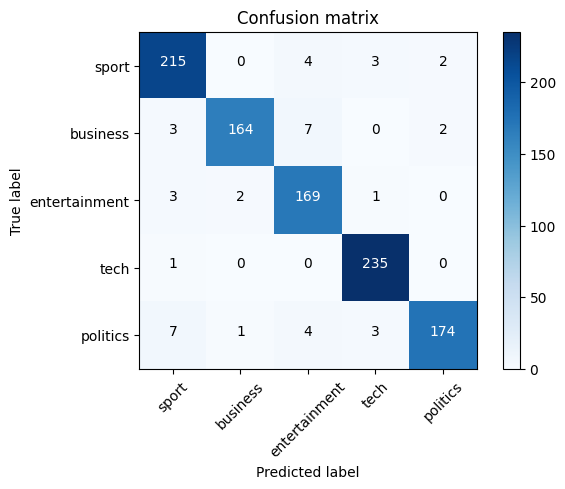

In [28]:
plot_confusion_matrix(cm, classes = label_dict.values())

In [29]:
print(classification_report(y_true,y_pred))

               precision    recall  f1-score   support

     business       0.94      0.96      0.95       224
entertainment       0.98      0.93      0.96       176
     politics       0.92      0.97      0.94       175
        sport       0.97      1.00      0.98       236
         tech       0.98      0.92      0.95       189

     accuracy                           0.96      1000
    macro avg       0.96      0.95      0.96      1000
 weighted avg       0.96      0.96      0.96      1000

